In [8]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import beamsim

# Set seaborn style for beautiful plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot1_local_aggregation(items, ax: plt.Axes = None, topology_name=""):
    """Plot SNARK1 distribution for local aggregation only mode"""
    _, _, validator_count, snark1_threshold, snark2_threshold = beamsim.filter_report(
        items, "info"
    )[0]
    snark1_sent = beamsim.get_snark1_sent(items)
    snark1_received = beamsim.get_snark1_received(items)
    
    # Note: In local aggregation only mode, there should be no SNARK2
    snark2_sent = beamsim.filter_report(items, "snark2_sent")

    show = ax is None
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))

    # Use seaborn color palette
    colors = sns.color_palette("husl", 3)

    # Plot with enhanced styling
    ax.step(
        *snark1_sent,
        where="post",
        color=colors[0],
        linewidth=2.5,
        label="SNARK1 Sent (Cumulative)",
        alpha=0.8,
    )
    ax.step(
        [0, *beamsim.time_axis(snark1_received)],
        [0, *[x[2] for x in snark1_received]],
        where="post",
        color=colors[1],
        linewidth=2.5,
        label="SNARK1 Received",
        alpha=0.8,
    )

    # Enhanced reference lines
    ax.axhline(
        validator_count,
        linestyle=":",
        color=colors[0],
        alpha=0.7,
        linewidth=2,
        label=f"Validator Count ({validator_count})",
    )
    ax.axhline(
        snark1_threshold,
        linestyle="--",
        color=colors[0],
        alpha=0.7,
        linewidth=2,
        label=f"SNARK1 Threshold ({snark1_threshold})",
    )

    # In local aggregation only mode, SNARK2 should not exist
    if snark2_sent:
        print("Warning: SNARK2 found in local aggregation only mode!")
        snark2_time = snark2_sent[0][0]
        ax.axvline(
            snark2_time,
            linestyle=":",
            color=colors[2],
            alpha=0.8,
            linewidth=2,
            label=f"SNARK2 Sent Time ({snark2_time})",
        )

    # Enhanced styling
    ax.set_xlabel("Time (ms)", fontweight="bold")
    ax.set_ylabel("Count", fontweight="bold")
    if topology_name:
        ax.set_title(
            f"SNARK1 Distribution (Local Aggregation Only) - {topology_name.title()} Topology",
            fontweight="bold",
            fontsize=14,
        )

    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)

    if show:
        plt.tight_layout()
        plt.show()


def plot1_topologies_local_aggregation(topologies=beamsim.topologies, **run_kwargs):
    """Plot SNARK1 distribution across topologies for local aggregation only mode"""
    # Create enhanced subplots with better spacing
    fig, axes = plt.subplots(nrows=len(topologies), figsize=(12, 15), sharex=True)
    fig.suptitle(
        "SNARK1 Distribution (Local Aggregation Only) Across Network Topologies",
        fontsize=16,
        fontweight="bold",
        y=0.95,
    )

    for topology, ax in zip(topologies, axes):
        plot1_local_aggregation(
            beamsim.run(**run_kwargs, t=topology, local_aggregation_only=True), 
            ax, 
            beamsim.topology_name[topology]
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [3]:
def plot2_local_aggregation(items, ax: plt.Axes = None, topology_name=""):
    """Plot network traffic by role for local aggregation only mode"""
    metrics = beamsim.Metrics(items)

    show = ax is None
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))

    # Create a more structured data approach
    time_points = range(metrics.t)
    colors = sns.color_palette("Set2", 3)

    for y, label, color in zip(metrics.bytes_sent_role_avg, beamsim.role_name, colors):
        ax.plot(
            time_points,
            y,
            label=label,
            linewidth=3,
            color=color,
            marker="o",
            markersize=4,
            alpha=0.8,
        )

    ax.set_xlabel("Time Step", fontweight="bold")
    ax.set_ylabel("Average Bytes Sent", fontweight="bold")
    if topology_name:
        ax.set_title(
            f"Network Traffic by Role (Local Aggregation Only) - {topology_name} Topology",
            fontweight="bold",
            fontsize=14,
        )

    ax.legend(frameon=True, fancybox=True, shadow=True, loc="upper left")
    ax.grid(True, alpha=0.3)

    # Add some styling enhancements
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if show:
        plt.tight_layout()
        plt.show()


def plot2_topologies_local_aggregation(topologies=beamsim.topologies, **run_kwargs):
    """Plot network traffic analysis across topologies for local aggregation only mode"""
    # Create a comprehensive comparison plot
    fig, axes = plt.subplots(
        nrows=len(topologies), figsize=(14, 12), sharex=True, sharey=True
    )
    fig.suptitle(
        "Network Traffic Analysis (Local Aggregation Only) Across Topologies",
        fontsize=16,
        fontweight="bold",
        y=0.95,
    )

    # Run simulations and plot
    for topology, ax in zip(topologies, axes):
        items = beamsim.run(**run_kwargs, t=topology, local_aggregation_only=True)
        plot2_local_aggregation(items, ax, beamsim.topology_name[topology])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [4]:
def plot3_topologies_local_aggregation(topologies=beamsim.topologies, **run_kwargs):
    """Plot total network traffic for local aggregation only mode"""
    # Additional: Create separate plots for sent and received bytes
    _, axes = plt.subplots(2, 1, figsize=(12, 16))

    def plot(ax: plt.Axes, f_data_role, title, ylabel):
        # Collect data for all topologies
        all_data = []
        for topology in topologies:
            items = beamsim.run(**run_kwargs, t=topology, local_aggregation_only=True)
            metrics = beamsim.Metrics(items)

            # Calculate total bytes sent and received for each role
            for data, role in zip(f_data_role(metrics), beamsim.role_name):
                all_data.append(
                    {
                        "Topology": beamsim.topology_name[topology],
                        "Role": role,
                        "Total Bytes (MB)": data[-1] / (1024 * 1024),
                    }
                )

        # Create DataFrames
        df = pd.DataFrame(all_data)

        sns.barplot(data=df, x="Topology", y="Total Bytes (MB)", hue="Role", ax=ax)
        ax.set_title(title + " (Local Aggregation Only)", fontweight="bold", fontsize=14)
        ax.set_ylabel(ylabel, fontweight="bold")
        ax.set_xlabel("Network Topology", fontweight="bold")
        ax.legend(title="Node Role", frameon=True, fancybox=True, shadow=True)

    # Plot sent bytes
    plot(
        axes[0],
        lambda metrics: metrics.bytes_sent_role,
        "Total Sent Network Traffic by Topology and Role",
        "Total Bytes Sent (MB)",
    )
    # Plot received bytes
    plot(
        axes[1],
        lambda metrics: metrics.bytes_received_role,
        "Total Received Network Traffic by Topology and Role",
        "Total Bytes Received (MB)",
    )

    plt.tight_layout()
    plt.show()

In [5]:
def plot4_topologies_local_aggregation(topologies=beamsim.topologies, **run_kwargs):
    """Plot peak network traffic for local aggregation only mode"""
    import warnings

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        all_data = []
        for topology in topologies:
            items = beamsim.run(**run_kwargs, t=topology, local_aggregation_only=True)
            metrics = beamsim.Metrics(items)
            for data_role, direction in [
                (metrics.bytes_sent_role_avg, "Outgoing"),
                (metrics.bytes_received_role_avg, "Incoming"),
            ]:
                for data, role in zip(data_role, beamsim.role_name):
                    window = 1000  # 1000ms window
                    windows = len(data) - window
                    if windows > 0:
                        peak = max(data[i + window] - data[i] for i in range(windows))
                    else:
                        peak = data[-1]
                    peak_mbps = (peak * 8) / (1000 * 1000)  # bytes -> bits -> Mbps
                    all_data.append(
                        {
                            "Topology": beamsim.topology_name[topology],
                            "Role": role,
                            "Peak": peak_mbps,
                            "Direction": direction,
                        }
                    )
        df = pd.DataFrame(all_data)
        g = sns.catplot(
            data=df,
            x="Topology",
            y="Peak",
            hue="Role",
            col="Direction",
            kind="bar",
            ci=None,
            height=7,
            aspect=1.1,
            dodge=True,
            legend_out=False,
        )
        g.set_titles("{col_name} Traffic (Local Aggregation Only)")
        g.set_axis_labels("Network Topology", "Peak Traffic (Mbps)")
        g.figure.suptitle(
            "Peak Network Traffic by Topology, Role, and Direction (Local Aggregation Only)",
            fontweight="bold",
            fontsize=15,
            y=1.05,
        )
        for ax in g.axes.flat:
            ax.set_ylabel("Peak Traffic (Mbps)", fontweight="bold")
            ax.set_xlabel("Network Topology", fontweight="bold")
            ax.grid(True, axis="y", alpha=0.3)
        g.add_legend(
            title="Role", frameon=True, fancybox=True, shadow=True
        )  # Ensure legend is displayed
        plt.tight_layout()
        plt.show()

In [6]:
# Default YAML Configuration for Local Aggregation Only Simulations
# This configuration is specifically tuned for local aggregation only mode
# The simulation stops after local aggregators generate SNARK1

yaml_config_path = beamsim.yaml("""
# Simulation Backend Configuration. Options: delay, queue, ns3-direct
# - delay: Simple delay-based network simulation
# - queue: Queue-based network simulation with more realistic modeling
# - ns3-direct: NS-3 simulation with direct peer connections
backend: ns3-direct
                                
snark1_pull: true
snark1_half_direct: true

# Network Topology Configuration. Options: direct, gossip, grid
topology: gossip

# Whether to shuffle validators from the same group to different routers
shuffle: false

# Seed for reproducible simulation results
random_seed: 42

# Role Assignment Configuration
# Note: Global aggregators are less relevant in local aggregation only mode
roles:
  # Number of validator groups (affects parallel processing and aggregation)
  group_count: 8
  
  # Number of validators per group (including local aggregators)
  group_validator_count: 100
  
  # Number of local aggregators per group (more important in this mode)
  group_local_aggregator_count: 10

  # Total number of global aggregators (not used in local aggregation only)
  global_aggregator_count: 10

# Gossipsub Network Configuration (only applies when topology=gossip)
gossip:
  # Target number of peers in the mesh network for each topic
  mesh_n: 6
  
  # Number of non-mesh peers to maintain connections with
  non_mesh_n: 4

# Cryptographic Constants
consts:
  # Time for each validator to generate their initial signature
  signature_time: 20ms
  
  # Size of individual signatures in bytes (affects network traffic)
  signature_size: 3072
  
  # Size of SNARK proofs in bytes (significantly affects bandwidth)
  snark_size: 131072
  
  # Threshold fraction of signatures needed for SNARK1 generation (0.0-1.0)
  snark1_threshold: 0.75
  
  # Threshold fraction of signatures needed for final SNARK2 (not used in local aggregation only)
  snark2_threshold: 0.66
  
  # Rate of signature aggregation (signatures per second)
  aggregation_rate_per_sec: 1000
  
  # Rate of SNARK proof recursion/aggregation (proofs per second)
  snark_recursion_aggregation_rate_per_sec: 50
  
  # Time to verify a single post-quantum signature
  pq_signature_verification_time: 30us
  
  # Time to verify a single SNARK proof
  snark_proof_verification_time: 5ms

# Network Simulation Parameters
network:
  # Take latencies from shadow atlas file
  gml: "shadow-atlas.bin"
""")

Running beamsim simulations with --local-aggregation-only flag...
This mode stops simulation after local aggregators generate SNARK1
No global aggregation or SNARK2 generation will occur.

run: mpirun -n 9 build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beamsim-yaml-md5/00b48badc5b21749a4511cf64ce8dfc3 -t gossip --local-aggregation-only --report
run: mpirun -n 9 build/beamsim -c /var/folders/r9/53ggp_3x6w51pqj8_kv1_lb00000gn/T/beamsim-yaml-md5/00b48badc5b21749a4511cf64ce8dfc3 -t grid --local-aggregation-only --report


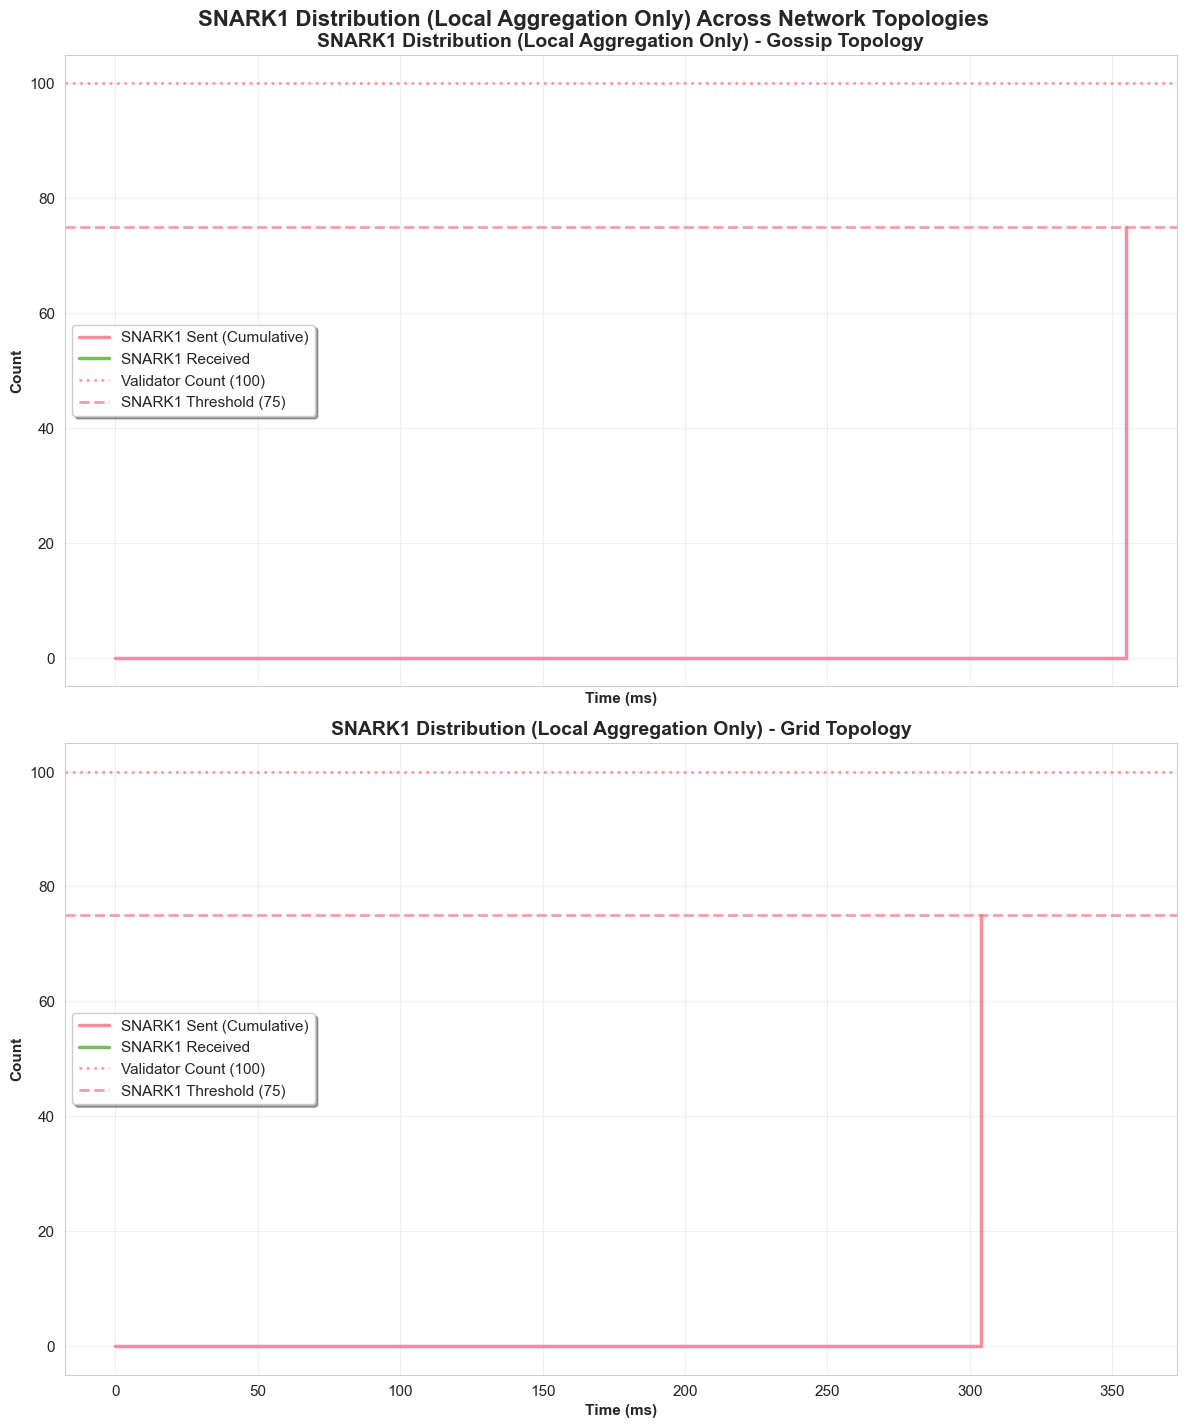

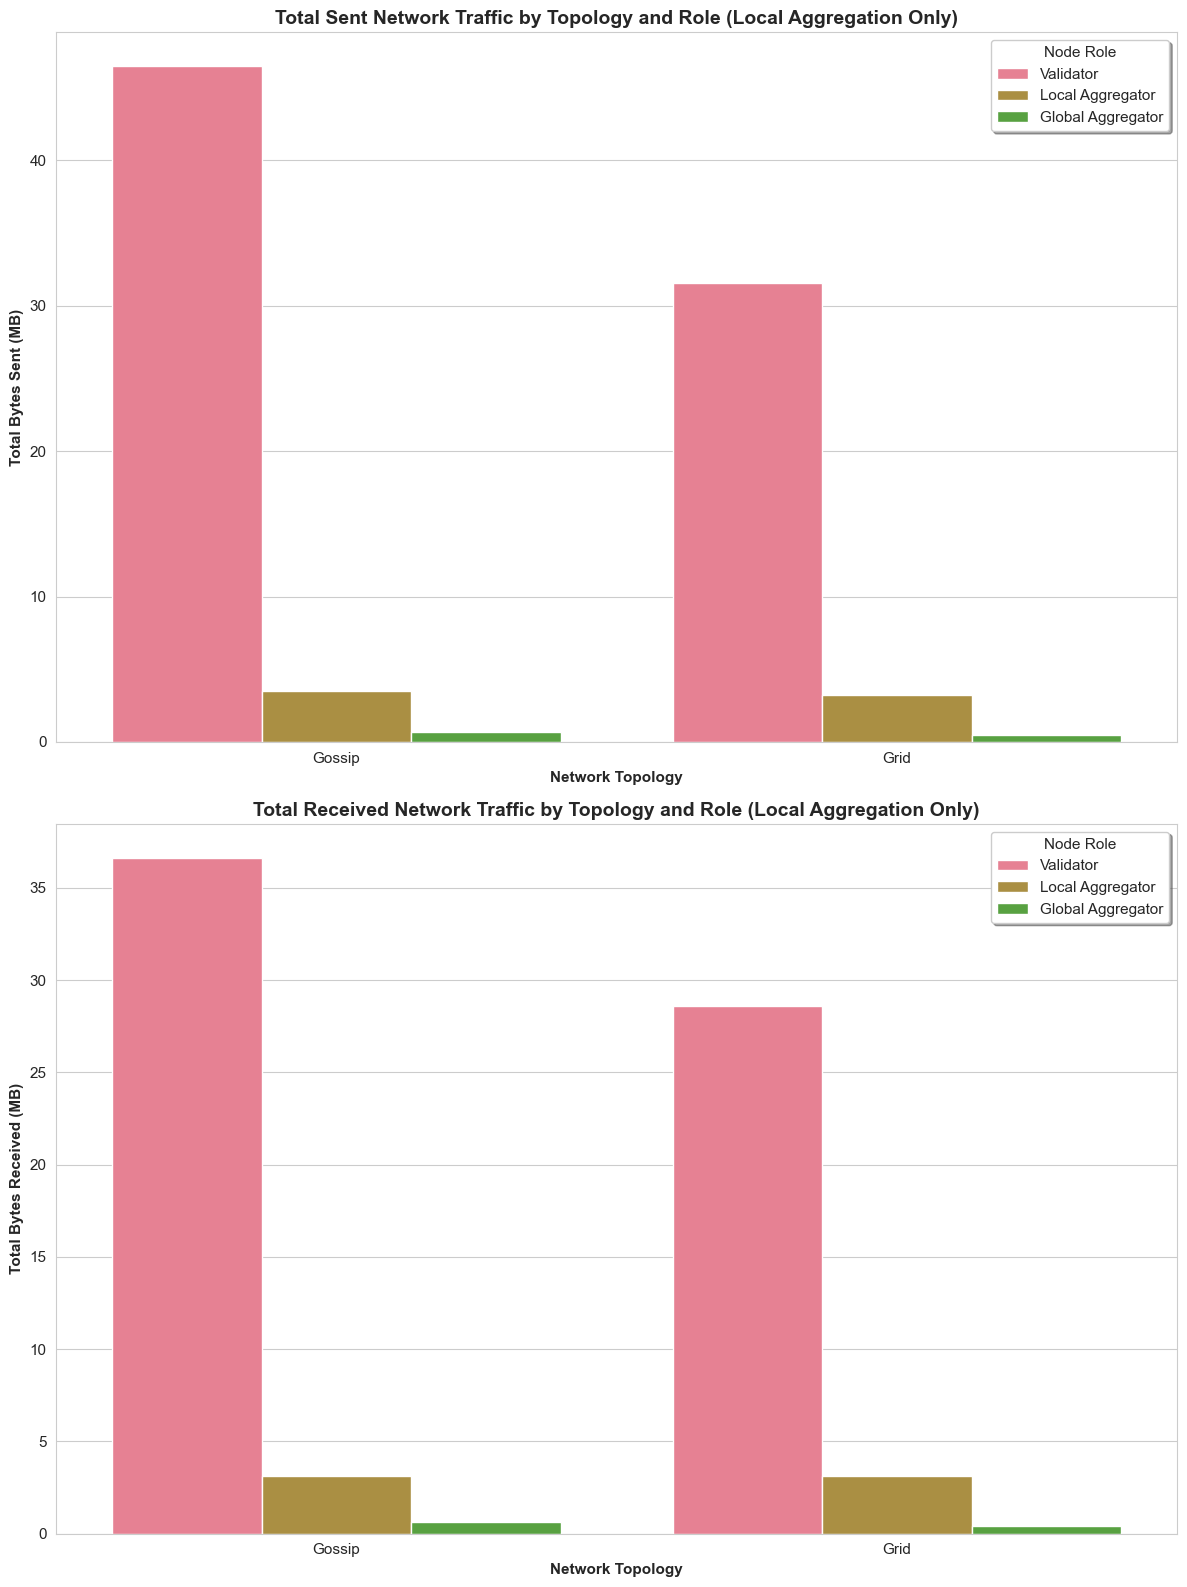

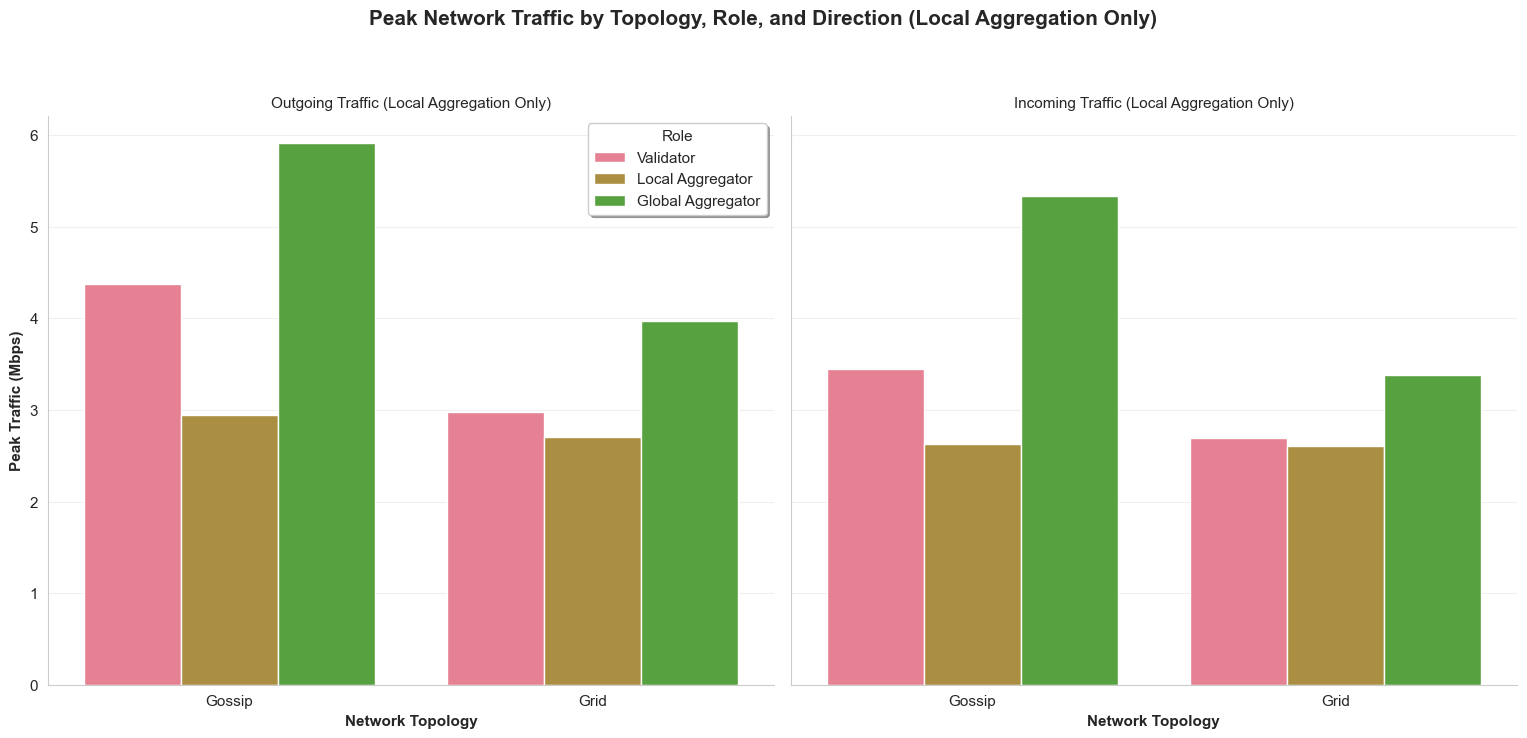

In [9]:
# Run simulations using YAML config as defaults with LOCAL AGGREGATION ONLY mode
# CLI flags can override the YAML configuration values
# The simulator binary loads YAML config first, then applies CLI flag overrides
# The --local-aggregation-only flag stops simulation after local aggregators generate SNARK1

# Optional CLI flag overrides (uncomment and modify as needed)
run_kwargs = dict(
    c=yaml_config_path,
    # Uncomment any of these to override the YAML config defaults:
    # b="ns3-direct",  # backend override
    # g=10,  # groups override
    # gv=128,  # group validators override
    mpi=9,  # enable MPI: set to False to disable, alternatively set to number of processes
    # la=1,  # local aggregators override
    # ga=1,  # global aggregators override (not used in local aggregation only)
    # shuffle=False,  # shuffle override
    # Note: local_aggregation_only=True is set automatically in the plotting functions
)

topologies = ["gossip", "grid"]

print("Running beamsim simulations with --local-aggregation-only flag...")
print("This mode stops simulation after local aggregators generate SNARK1")
print("No global aggregation or SNARK2 generation will occur.\n")

plot1_topologies_local_aggregation(topologies, **run_kwargs)
# plot2_topologies_local_aggregation(topologies, **run_kwargs)
plot3_topologies_local_aggregation(topologies, **run_kwargs)
plot4_topologies_local_aggregation(topologies, **run_kwargs)

## Local Aggregation Only Mode Analysis

This notebook runs beamsim simulations with the `--local-aggregation-only` flag, which has the following characteristics:

### Key Differences from Full Simulation:

1. **Stops at Local Aggregation**: The simulation terminates after local aggregators generate SNARK1 proofs
2. **No Global Aggregation**: No global aggregators are used, and no SNARK2 generation occurs
3. **Reduced Network Traffic**: Only signature collection and SNARK1 generation traffic is observed
4. **Faster Simulation**: Simulations complete more quickly as they don't include the global aggregation phase

### Use Cases:

- **Local Aggregation Performance**: Analyze how efficiently validators can aggregate signatures at the local level
- **Network Bottleneck Analysis**: Identify potential bottlenecks in the signature collection phase
- **Topology Comparison**: Compare different network topologies for local aggregation efficiency
- **Resource Planning**: Understand resource requirements for the signature collection and local aggregation phases

### Metrics to Focus On:

- **SNARK1 Generation Time**: How quickly local aggregators can generate SNARK1 proofs
- **Network Traffic Patterns**: Traffic patterns during signature collection and local aggregation
- **Validator Role Performance**: How different validator roles perform in the local aggregation phase
- **Topology Efficiency**: Which network topology is most efficient for local aggregation